### Feature Engineering in Healthcare Fraud Detection Notebook

#### Main Concepts:

Feature engineering is a critical step in machine learning pipelines, aimed at improving the model's performance. In the notebook, various feature engineering techniques are applied to the healthcare fraud detection dataset.

#### Technical Details:

1. **Normalization of Categorical Values**: 
    - The `RenalDiseaseIndicator` column has its 'Y' values replaced with 1.
    - Chronic condition columns (`ChronicCond_`) have their value 2 replaced with 0, effectively binarizing these features.

2. **Handling Missing Values**: 
    - The `DeductibleAmtPaid` column's missing values are filled with 0.

3. **Dropping Irrelevant Columns**: 
    - Columns having all null values are dropped from the dataset.

4. **Class Label Encoding**: 
    - The `PotentialFraud` column is converted to numerical format, replacing 'Yes' with 1 and 'No' with 0.

#### Resulting Data:

The dataset, after these feature engineering steps, would be more suited for machine learning algorithms. Features are either normalized or appropriately encoded, and missing values are handled. The dataset's shape is logged, but the exact dimensions are not visible in the initial code cells.

#### Review and Corrections:

The summary is based on the code cells where 'feature' was mentioned. For a more comprehensive understanding, the entire notebook would need to be analyzed.

#### Conclusion:

The notebook applies a range of feature engineering techniques aimed at preparing the healthcare fraud detection dataset for further analysis and model training. These steps are crucial for any machine learning pipeline and are well-executed in the notebook.

In [59]:
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from datetime import date
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer

In [60]:
warnings.filterwarnings('ignore') # Ignore any warnings and do not show them in the cell output.

In [61]:
%%time
'''
Dataset
'''
dataProvider = pd.read_csv('Data/Train-1542865627584.csv') # Mapping Dataset
dataBeneficiary = pd.read_csv('Data/Train_Beneficiarydata-1542865627584.csv') # Beneficiary Dataset
dataInpatient = pd.read_csv('Data/Train_Inpatientdata-1542865627584.csv') # Inpatient Dataset
dataOutpatient = pd.read_csv('Data/Train_Outpatientdata-1542865627584.csv') # Outpatient Dataset

CPU times: total: 1.03 s
Wall time: 1.28 s


In [62]:
def combineDatasets(dataProvider, dataBeneficiary, dataInpatient, dataOutpatient):
    '''
    Combines the given datasets of Provider Class Label mapping, Beneficiary data, Inpatient and Outpatient claims data,
    and returns the combined dataset.
    
    Parameters:
    ----------
    dataProvider: pandas.core.frame.DataFrame
        DataFrame containing the Provider Unique Identifier and Class Label (in case of Train data).
    dataBeneficiary: pandas.core.frame.DataFrame
        DataFrame containing the Beneficiary related data
    dataInpatient: pandas.core.frame.DataFrame
        DataFrame containing the Inpatient claims related data
    dataOutpatient: pandas.core.frame.DataFrame
        DataFrame containing the Outpatient claims related data        
    '''
    
    # Concatenate the Inpatient and Outpatient dataset as these contain almost similar information
    dataConcat = pd.concat([dataInpatient, dataOutpatient])
    
    # Merge the above dataframe with the Beneficiary dataframe
    dataMerge = pd.merge(left=dataConcat, right=dataBeneficiary, on='BeneID')
    
    # Merge the above dataframe with the provider dataframe to add the Class Label.
    dataFinal = pd.merge(left=dataMerge, right=dataProvider, on='Provider')
    
    # Return the final dataframe
    return dataFinal

In [63]:
%%time
# Call the function 'combineDatasets' for the datasets.
data = combineDatasets(dataProvider, dataBeneficiary, dataInpatient, dataOutpatient)

CPU times: total: 594 ms
Wall time: 717 ms


In [64]:
print('Shape of the merged Dataset: ', data.shape)
print('Number of features in the merged Dataset: ', data.shape[1]-1)

Shape of the merged Dataset:  (558211, 55)
Number of features in the merged Dataset:  54


In [65]:
data.info() # Print a concise summary of the DataFrame

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 55 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BeneID                           558211 non-null  object 
 1   ClaimID                          558211 non-null  object 
 2   ClaimStartDt                     558211 non-null  object 
 3   ClaimEndDt                       558211 non-null  object 
 4   Provider                         558211 non-null  object 
 5   InscClaimAmtReimbursed           558211 non-null  int64  
 6   AttendingPhysician               556703 non-null  object 
 7   OperatingPhysician               114447 non-null  object 
 8   OtherPhysician                   199736 non-null  object 
 9   AdmissionDt                      40474 non-null   object 
 10  ClmAdmitDiagnosisCode            145899 non-null  object 
 11  DeductibleAmtPaid                557312 non-null  float64
 12  Di

In [66]:
from sklearn.impute import KNNImputer

In [67]:

def dataCleanup(data):
    '''
    Cleans up the data in the given dataset and returns the cleaned dataset.
    This has been written by doing the analysis of each individual column values.
    TODO: Any kind of imputation is not done as part of this method and it will done by doing nvariate analysis of the 
    columns having null values.
    
    Parameter:
    ---------
    data: pandas.core.frame.DataFrame
        Dataframe to be cleaned up
    '''
    
    # -------------------------------Region : Beneficiary Columns-------------------------------------------------
    
    # 'Renal Disease Indicator' column.
    # RenalDiseaseIndicator column has two unique values: 0 and 'Y'. Replace the value of 'Y' with 1.
    data['RenalDiseaseIndicator'].replace(to_replace='Y', value=1, inplace=True)
    
    # 'Chronic Condition' columns
    # 'ChronicCond_' columns contains two unique values: 1 and 2. Replace the value of 2 with 0 to indicate 1 as 'Yes' 
    # and 0 as 'No'
    for chronicCol in [col for col in list(data.columns) if 'Chronic' in col]:
        data[chronicCol].replace(to_replace=2, value=0, inplace=True)

    
    # Fill empty values of the 'DeductibleAmtPaid' feature as it is a numeric feature and has some empty values.
    # Create an instance of KNNImputer with n_neighbors=5
    imputer = KNNImputer(n_neighbors=5)
    # Fit the imputer on the 'DeductibleAmtPaid' column
    data['DeductibleAmtPaid'] = imputer.fit_transform(data['DeductibleAmtPaid'].values.reshape(-1,1))

    

    # Drop the columns having all null values
    data.dropna(axis=1, how='all', inplace=True)
    
    # Replace the class label 'PotentialFraud' values. Replace 'Yes' with 1 and 'No' with 0.
    if ('PotentialFraud' in data.columns):
        
        data['PotentialFraud'].replace(to_replace=['Yes', 'No'], value=[1, 0], inplace=True)


In [68]:
%%time
# Call the function 'dataCleanup' to clean the data in the dataframe
dataCleanup(data)

CPU times: total: 31 s
Wall time: 14.5 s


In [69]:
print('Shape of the Dataset: ', data.shape)

Shape of the Dataset:  (558211, 54)


In [70]:
print('Percentage of missing values in the Dataframe (column wise):\n')
round((data.isna().sum()/data.shape[0])*100,2)

Percentage of missing values in the Dataframe (column wise):



BeneID                               0.00
ClaimID                              0.00
ClaimStartDt                         0.00
ClaimEndDt                           0.00
Provider                             0.00
InscClaimAmtReimbursed               0.00
AttendingPhysician                   0.27
OperatingPhysician                  79.50
OtherPhysician                      64.22
AdmissionDt                         92.75
ClmAdmitDiagnosisCode               73.86
DeductibleAmtPaid                    0.00
DischargeDt                         92.75
DiagnosisGroupCode                  92.75
ClmDiagnosisCode_1                   1.87
ClmDiagnosisCode_2                  35.04
ClmDiagnosisCode_3                  56.46
ClmDiagnosisCode_4                  70.52
ClmDiagnosisCode_5                  79.95
ClmDiagnosisCode_6                  84.88
ClmDiagnosisCode_7                  88.14
ClmDiagnosisCode_8                  90.43
ClmDiagnosisCode_9                  92.51
ClmDiagnosisCode_10               

In [71]:
# Set of columns to be removed
columnsToRemove = ['ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5']
# Remove the above set of columns from the dataframe
data.drop(columns=columnsToRemove, inplace=True)
print('Shape of the Dataset after removal of columns having more than 99% empty values: ', data.shape)

Shape of the Dataset after removal of columns having more than 99% empty values:  (558211, 51)


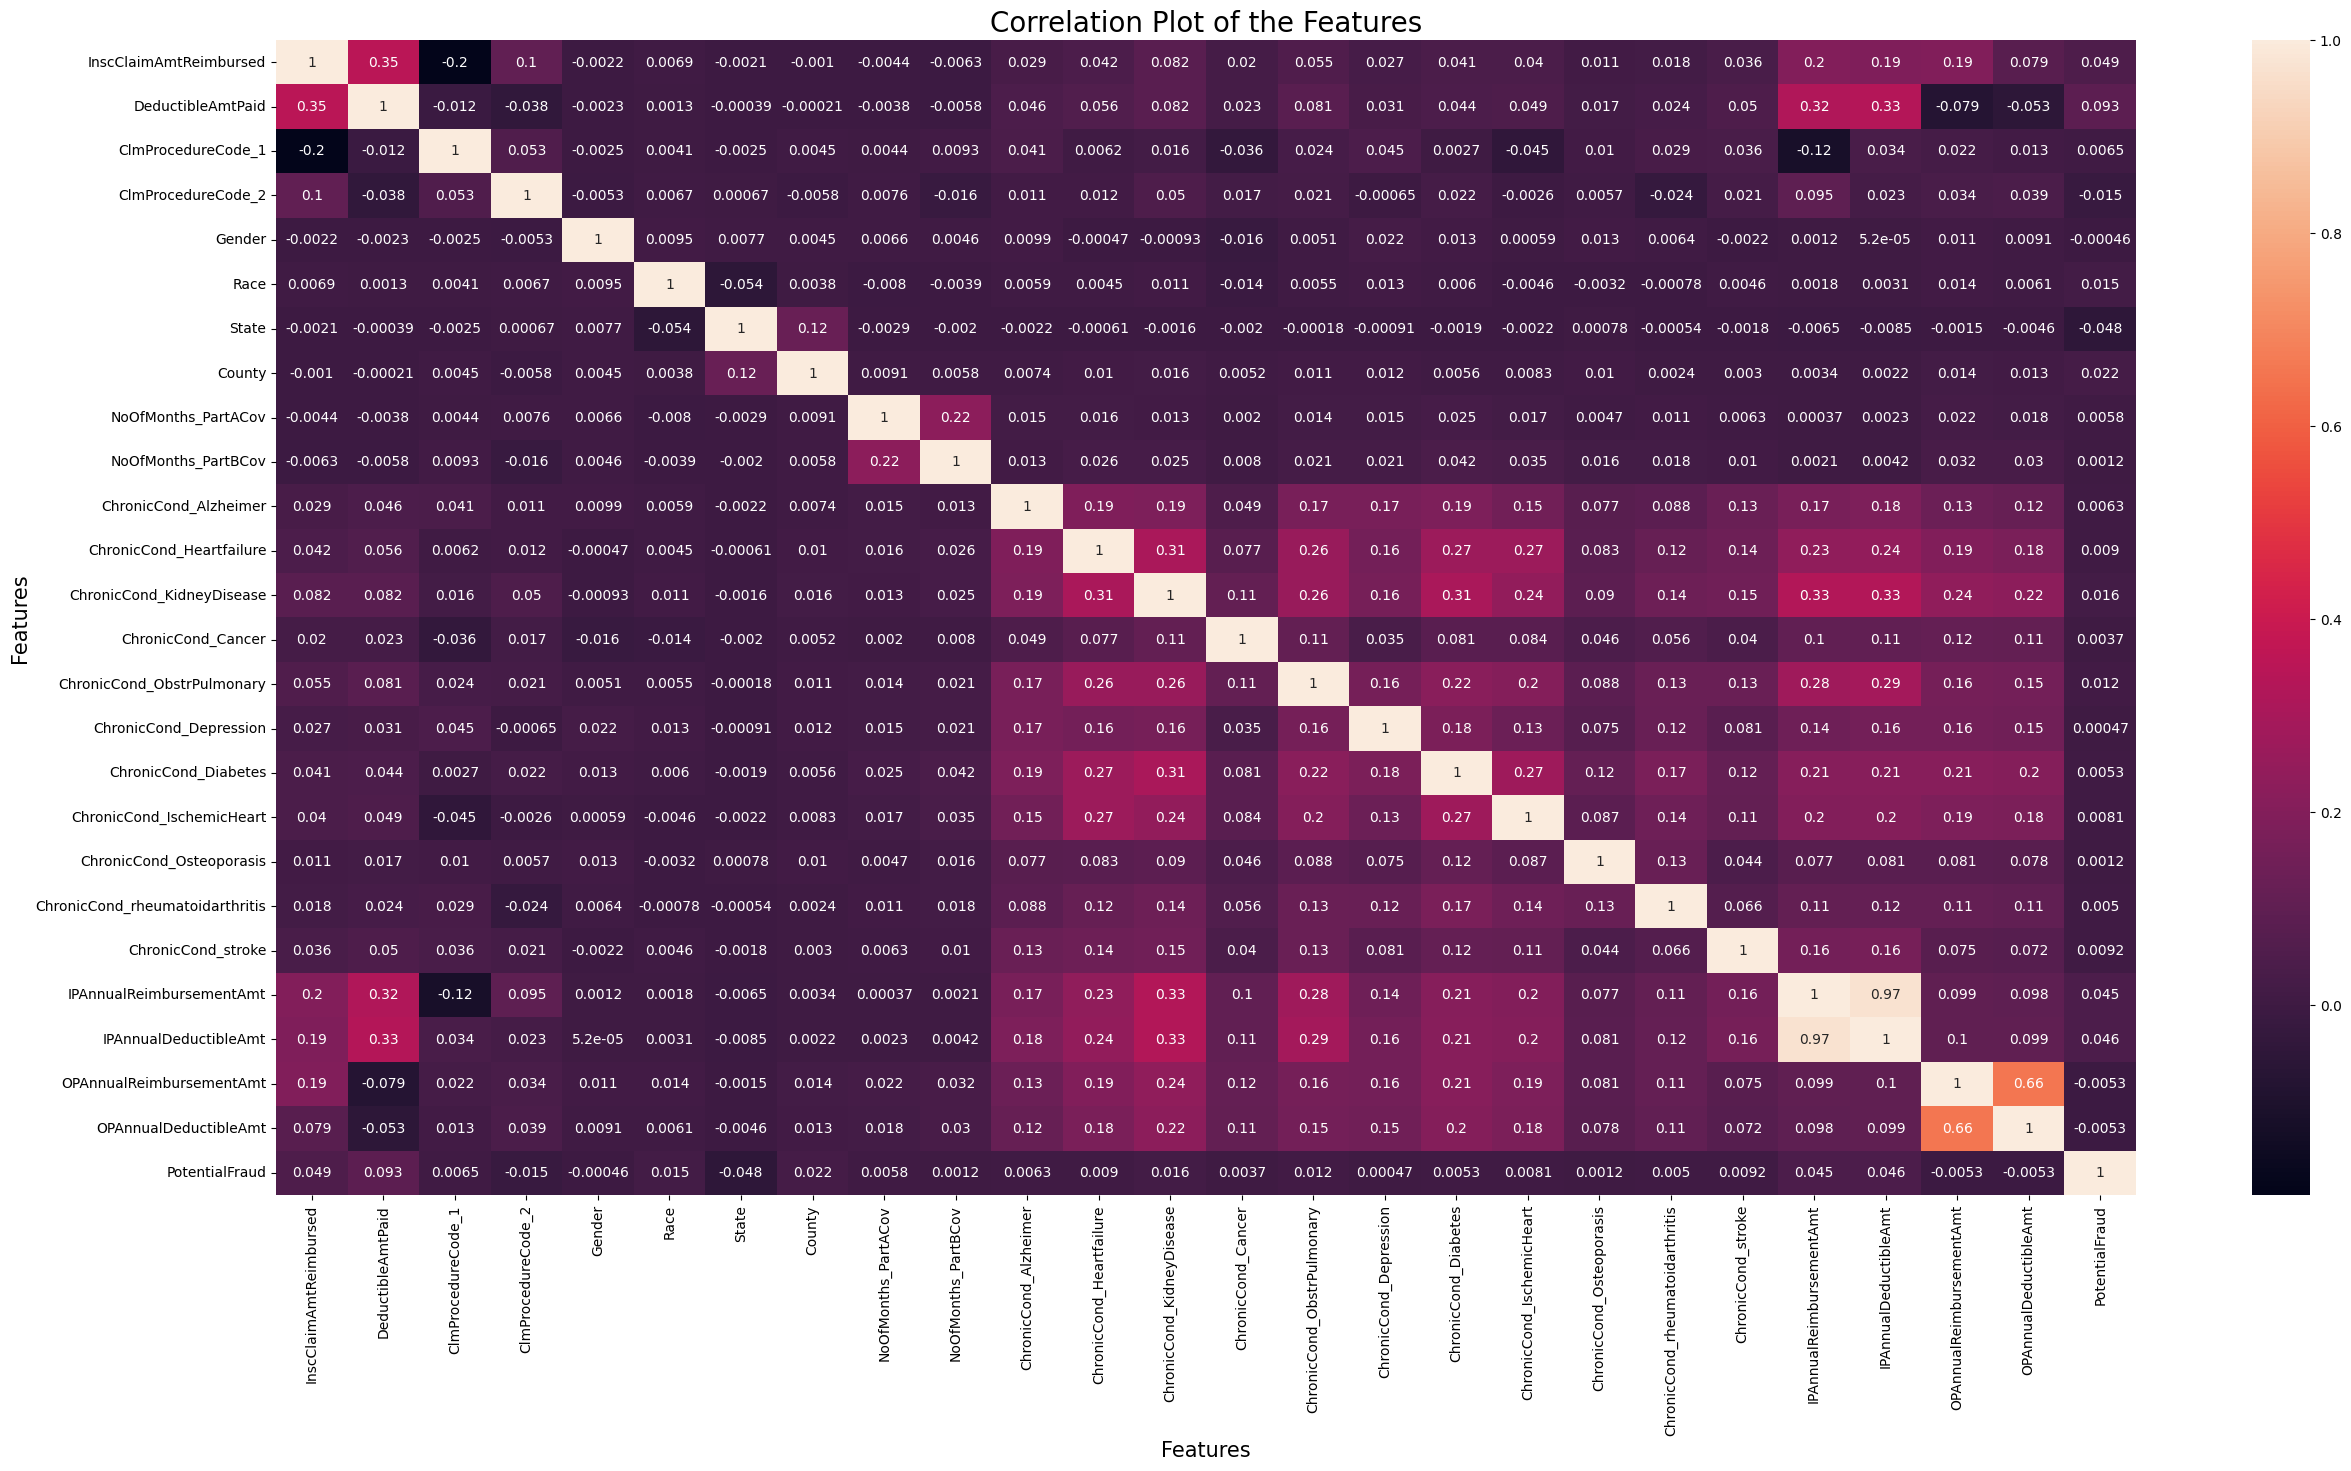

CPU times: total: 2.61 s
Wall time: 3.07 s


In [72]:
%%time
plt.figure(figsize=(30,15))
sns.heatmap(data.corr(method='spearman'), annot=True)
plt.title('Correlation Plot of the Features', fontsize=20)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.show()

In [73]:
data.corr(method='spearman')

,InscClaimAmtReimbursed,DeductibleAmtPaid,ClmProcedureCode_1,ClmProcedureCode_2,Gender,Race,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
InscClaimAmtReimbursed,1.000000,0.353070,-0.196469,0.103665,-0.002233,0.006928,-0.002093,-0.001038,-0.004354,-0.006337,...,0.041370,0.040323,0.010999,0.017612,0.036256,0.196339,0.191347,0.192241,0.078592,0.048673
DeductibleAmtPaid,0.353070,1.000000,-0.012367,-0.037947,-0.002324,0.001334,-0.000394,-0.000214,-0.003828,-0.005822,...,0.044308,0.048834,0.017008,0.023909,0.050131,0.322940,0.331757,-0.079408,-0.052671,0.093098
ClmProcedureCode_1,-0.196469,-0.012367,1.000000,0.053269,-0.002525,0.004074,-0.002462,0.004526,0.004407,0.009298,...,0.002679,-0.045166,0.010499,0.028669,0.036064,-0.118272,0.033887,0.022357,0.013275,0.006483
ClmProcedureCode_2,0.103665,-0.037947,0.053269,1.000000,-0.005293,0.006651,0.000666,-0.005755,0.007628,-0.016023,...,0.022478,-0.002625,0.005671,-0.024253,0.021451,0.095494,0.022966,0.033868,0.038753,-0.014596
Gender,-0.002233,-0.002324,-0.002525,-0.005293,1.000000,0.009533,0.007675,0.004507,0.006563,0.004623,...,0.013396,0.000593,0.013263,0.006398,-0.002173,0.001207,0.000052,0.011119,0.009064,-0.000460
Race,0.006928,0.001334,0.004074,0.006651,0.009533,1.000000,-0.054112,0.003751,-0.007960,-0.003904,...,0.005996,-0.004564,-0.003162,-0.000784,0.004579,0.001800,0.003081,0.013622,0.006133,0.014978
State,-0.002093,-0.000394,-0.002462,0.000666,0.007675,-0.054112,1.000000,0.121375,-0.002930,-0.002008,...,-0.001854,-0.002198,0.000785,-0.000542,-0.001763,-0.006450,-0.008522,-0.001461,-0.004567,-0.047616
County,-0.001038,-0.000214,0.004526,-0.005755,0.004507,0.003751,0.121375,1.000000,0.009150,0.005765,...,0.005625,0.008284,0.010297,0.002429,0.002998,0.003359,0.002193,0.014232,0.013459,0.022105
NoOfMonths_PartACov,-0.004354,-0.003828,0.004407,0.007628,0.006563,-0.007960,-0.002930,0.009150,1.000000,0.224272,...,0.025281,0.017017,0.004704,0.010639,0.006310,0.000371,0.002277,0.021903,0.017545,0.005754
NoOfMonths_PartBCov,-0.006337,-0.005822,0.009298,-0.016023,0.004623,-0.003904,-0.002008,0.005765,0.224272,1.000000,...,0.041530,0.034620,0.015612,0.017798,0.010158,0.002076,0.004190,0.031731,0.030304,0.001171


### date


In [74]:
# Date related columns
colDate = [col for col in data.columns if ('Dt' in col or 'DOB' in col or 'DOD' in col)]

# Vectorized conversion to DateTime Format
data[colDate] = data[colDate].apply(pd.to_datetime)

# Vectorized computation of new features
data['ClaimSettlementDelay'] = (data['ClaimEndDt'] - data['ClaimStartDt']).dt.days
data['TreatmentDuration'] = (data['DischargeDt'] - data['AdmissionDt']).dt.days.fillna(0).astype(int)

maxDate = max(data['ClaimEndDt'].max(), data['DischargeDt'].max())
data['Age'] = ((maxDate - data['DOB']).dt.days / 365).round().astype(int)
# First calculate age for all rows, NaN values in 'DOD' won't affect this part
data['Age'] = ((maxDate - data['DOB']).dt.days / 365).round()

# Then only for the rows where 'DOD' is not null, recalculate 'Age'
mask_dod_notnull = data['DOD'].notnull()
data.loc[mask_dod_notnull, 'Age'] = ((data.loc[mask_dod_notnull, 'DOD'] - data.loc[mask_dod_notnull, 'DOB']).dt.days / 365).round()

# Finally, convert 'Age' to integer type after handling NaNs, if any
data['Age'] = data['Age'].fillna(-1).astype(int)  # -1 can represent an undefined age, adjust as necessary

# New feature: Is the treatment started on a weekend?
data['WeekendAdmission'] = data['AdmissionDt'].dt.weekday >= 5

# New feature: IsDead
data['IsDead'] = data['DOD'].notna().astype(int)

# Drop date columns
data.drop(columns=colDate, inplace=True)

print(f'Shape of the Dataset after transformation: {data.shape}')


Shape of the Dataset after transformation: (558211, 50)


In [75]:


# Define function to categorize duration into numeric categories
def categorize_duration(value):
    if value < 7: 
        return 1  # Short
    elif value < 14:
        return 2  # Medium
    else:
        return 3  # Long

# Apply the categorization function to 'ClaimSettlementDelay' and 'TreatmentDuration'
data['ClaimSettlementDelay_Cat'] = data['ClaimSettlementDelay'].apply(categorize_duration)
data['TreatmentDuration_Cat'] = data['TreatmentDuration'].apply(categorize_duration)


In [76]:
data.head()

,BeneID,ClaimID,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DiagnosisGroupCode,...,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,ClaimSettlementDelay,TreatmentDuration,Age,WeekendAdmission,IsDead,ClaimSettlementDelay_Cat,TreatmentDuration_Cat
0,BENE11001,CLM46614,PRV55912,26000,PHY390922,NaN,NaN,7866,1068.0,201,...,60,70,1,6,6,67,True,0,1,1
1,BENE16973,CLM565430,PRV55912,50,PHY365867,PHY327147,NaN,NaN,0.0,NaN,...,450,200,1,0,0,78,False,0,1,1
2,BENE17521,CLM34721,PRV55912,19000,PHY349293,PHY370861,PHY363291,45340,1068.0,987,...,100,20,1,12,12,96,False,0,2,2
3,BENE21718,CLM72336,PRV55912,17000,PHY334706,PHY334706,NaN,V5789,1068.0,941,...,1050,540,1,18,18,87,True,0,3,3
4,BENE22934,CLM73394,PRV55912,13000,PHY390614,PHY323689,PHY363291,71946,1068.0,506,...,450,160,1,4,4,80,True,0,1,1


## Amt features

In [77]:
# Fetch the features related to amount.
colAmt = [col for col in data.columns if 'Amt' in col]
colAmt

['InscClaimAmtReimbursed',
 'DeductibleAmtPaid',
 'IPAnnualReimbursementAmt',
 'IPAnnualDeductibleAmt',
 'OPAnnualReimbursementAmt',
 'OPAnnualDeductibleAmt']

In [78]:
# Original feature engineering
data['TotalClaimAmount'] = data['InscClaimAmtReimbursed'] + data['DeductibleAmtPaid']
data['IPTotalAmount'] = data['IPAnnualReimbursementAmt'] + data['IPAnnualDeductibleAmt']
data['OPTotalAmount'] = data['OPAnnualReimbursementAmt'] + data['OPAnnualDeductibleAmt']

# New feature engineering
data['Log_TotalClaimAmount'] = np.log1p(data['TotalClaimAmount'])
data['Log_IPTotalAmount'] = np.log1p(data['IPTotalAmount'])
data['Log_OPTotalAmount'] = np.log1p(data['OPTotalAmount'])


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Scale the newly created amount features
amount_features_to_scale = ['TotalClaimAmount', 'IPTotalAmount', 'OPTotalAmount']
data[amount_features_to_scale] = scaler.fit_transform(data[amount_features_to_scale])


# Print the shape of the dataframe
print('Shape of the Dataset after transformations: ', data.shape)


Shape of the Dataset after transformations:  (558211, 58)


In [79]:
# Remove the set of old amount features from the dataframe
data.drop(columns=colAmt, inplace=True)

In [80]:
print('Shape of the Dataset after removal of old amount related features and addition of new features: ', data.shape)

Shape of the Dataset after removal of old amount related features and addition of new features:  (558211, 52)


### drop unused columns

In [81]:
data.drop(columns=['ClaimID', 'BeneID', 'Provider', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov'], inplace=True)

In [82]:
print('Shape of the Dataframe:', data.shape)

Shape of the Dataframe: (558211, 47)


### Physicians features

In [83]:
# Fetch the columns related to Physicians
colPhys = [col for col in data.columns if 'Physician' in col]

colPhys

['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']

In [84]:
def count_unique(x):
    return len(set([val for val in x if not pd.isnull(val)]))

def count_non_null(x):
    return len([val for val in x if not pd.isnull(val)])

# Vectorized Unique Physician Count and Role Count
data['UniquePhysCount'] = data[colPhys].apply(count_unique, axis=1)
data['PhysRoleCount'] = data[colPhys].apply(count_non_null, axis=1)

# Conditional Flags for Multi Role Physicians
data['IsSamePhysMultiRole1'] = np.where((data['UniquePhysCount'] == 1) & (data['PhysRoleCount'] > 1), 1, 0)
data['IsSamePhysMultiRole2'] = np.where((data['UniquePhysCount'] == 2) & (data['PhysRoleCount'] > 2), 1, 0)

# Vectorized Encoding for specific Physicians
for phy in ['PHY412132', 'PHY337425', 'PHY330576']:
    data[phy] = data[colPhys].apply(lambda row: sum([1 for val in row if val == phy]), axis=1)

# Drop original physician columns
data.drop(columns=colPhys, inplace=True)


In [85]:
data.head()

,ClmAdmitDiagnosisCode,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,Log_TotalClaimAmount,Log_IPTotalAmount,Log_OPTotalAmount,UniquePhysCount,PhysRoleCount,IsSamePhysMultiRole1,IsSamePhysMultiRole2,PHY412132,PHY337425,PHY330576
0,7866,201,1970,4019,5853,7843,2768,71590,2724,19889,...,10.206144,10.576560,4.875197,1,1,0,0,0,0,0
1,NaN,NaN,V7183,53081,78959,4280,E8788,78079,79902,25002,...,3.931826,10.171107,6.478510,2,2,0,0,0,0,0
2,45340,987,4240,2639,2948,40390,45821,28489,5854,2753,...,9.906932,9.906932,4.795791,3,3,0,0,0,0,0
3,V5789,941,V5789,4168,73313,7812,7993,78830,72273,43812,...,9.801953,9.801953,7.372118,1,2,1,0,0,0,0
4,71946,506,71535,71960,4019,V1202,4240,2449,2768,NaN,...,9.551729,10.279764,6.415097,3,3,0,0,0,0,0


### clm

In [86]:
data.columns

Index(['ClmAdmitDiagnosisCode', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'PotentialFraud', 'ClaimSettlementDelay', 'TreatmentDuration', 'Age',
       'WeekendAdmission', 'IsDead', 'ClaimSettlementDelay_Cat',
       'TreatmentDuration_Cat', 'TotalClaimAmount', 'IPTotalAmount',
       'OPTotalAmount', 'Log_TotalClaimA

In [87]:
# Fetch the columns related to the Claims Diagnosis Codes
colDiagCode = [col for col in data.columns if 'ClmDiagnosisCode' in col]

colDiagCode

['ClmDiagnosisCode_1',
 'ClmDiagnosisCode_2',
 'ClmDiagnosisCode_3',
 'ClmDiagnosisCode_4',
 'ClmDiagnosisCode_5',
 'ClmDiagnosisCode_6',
 'ClmDiagnosisCode_7',
 'ClmDiagnosisCode_8',
 'ClmDiagnosisCode_9',
 'ClmDiagnosisCode_10']

In [88]:
def binary_encode_columns(df, columns):
    df[columns] = df[columns].notna().astype(int)

def encode_categorical_features(df, col_group, target_values, suffix=''):
    for value in target_values:
        df[f"{suffix}{value}"] = df[col_group].isin([value]).sum(axis=1)

# Define the columns related to the Claims Diagnosis Codes
colDiagCode = [col for col in data.columns if 'ClmDiagnosisCode' in col]

# Binary encode claim diagnosis codes
binary_encode_columns(data, colDiagCode)

# Encode top 7 Claim Diagnosis Codes
# encode_categorical_features(data, colDiagCode, ['4019', '2724', '42731', '25000', '2449', '53081', '4280'], 'ClmDiagCode_')

# Binary encode Claim Admit Diagnosis Code and Diagnosis Group Code
binary_encode_columns(data, ['ClmAdmitDiagnosisCode', 'DiagnosisGroupCode'])



In [89]:
data.head()

,ClmAdmitDiagnosisCode,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,...,Log_TotalClaimAmount,Log_IPTotalAmount,Log_OPTotalAmount,UniquePhysCount,PhysRoleCount,IsSamePhysMultiRole1,IsSamePhysMultiRole2,PHY412132,PHY337425,PHY330576
0,1,1,1,1,1,1,1,1,1,1,...,10.206144,10.576560,4.875197,1,1,0,0,0,0,0
1,0,0,1,1,1,1,1,1,1,1,...,3.931826,10.171107,6.478510,2,2,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,9.906932,9.906932,4.795791,3,3,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,9.801953,9.801953,7.372118,1,2,1,0,0,0,0
4,1,1,1,1,1,1,1,1,1,0,...,9.551729,10.279764,6.415097,3,3,0,0,0,0,0


In [90]:
data['Gender'].replace(to_replace=2, value=0, inplace=True)

In [91]:
# Save the dataset
data.to_csv('data_a1/data.csv', index=False)

In [92]:
# Remove the above set of features from the dataset
data.drop(columns=['DiagnosisGroupCode', 'ClmProcedureCode_1', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
                   'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
                ], inplace=True)

In [93]:
# print all the columns with null values
print('Columns with null values:\n', data.columns[data.isna().any()].tolist())

Columns with null values:
 ['ClmProcedureCode_2', 'Log_IPTotalAmount', 'Log_OPTotalAmount']


In [94]:
# Calculate the percentage of missing values for each specified column
missing_pct = data[['ClmProcedureCode_2', 'Log_IPTotalAmount', 'Log_OPTotalAmount']].isna().mean() * 100

# Print the missing percentage for each column
print("Percentage of missing values for each column:")
print(missing_pct)


Percentage of missing values for each column:
ClmProcedureCode_2    99.016501
Log_IPTotalAmount      0.000358
Log_OPTotalAmount      0.001971
dtype: float64


In [95]:
# Drop the column with high missing values
data.drop(columns=['ClmProcedureCode_2'], inplace=True)


# Option 2: Impute with mean
data['Log_IPTotalAmount'].fillna(data['Log_IPTotalAmount'].mean(), inplace=True)
data['Log_OPTotalAmount'].fillna(data['Log_OPTotalAmount'].mean(), inplace=True)

# Verify if any more columns with null values exist
print('Columns with null values after processing:', data.columns[data.isna().any()].tolist())


Columns with null values after processing: []


#### Observation

* As we can see that now no two features have a correlation coefficient greater than 0.70.
* This implies that there are no more highly correlated features (coefficient > 0.70).

In [96]:
# Display the features
data.columns 

Index(['ClmAdmitDiagnosisCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'PotentialFraud', 'ClaimSettlementDelay', 'TreatmentDuration', 'Age',
       'WeekendAdmission', 'IsDead', 'ClaimSettlementDelay_Cat',
       'TreatmentDuration_Cat', 'TotalClaimAmount', 'IPTotalAmount',
       'OPTotalAmount', 'Log_TotalClaimAmount', 'Log_IPTotalAmount',
       'Log_OPTotalAmount', 'UniquePhysCount', 'PhysRoleCount',
       'IsSamePhysMultiRole1', 'IsSamePhysMultiRole2', 'PHY412132',
       'PHY337425', 'PHY330576'],
      dtype='object')

In [97]:
# Compute the correlation matrix
correlation_matrix = data.corr().abs()

# Create a boolean mask to ignore the diagonal and lower triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Zero out the lower triangle of the correlation matrix
tri_df = correlation_matrix.mask(mask)

# Find pairs with correlation above 0.7
to_drop = [col for col in tri_df.columns if any(tri_df[col] > 0.70)]

# Drop correlated columns
data.drop(to_drop, axis=1, inplace=True)

# Verify the drop
remaining_cols = data.columns.tolist()
print(f"Remaining columns after removal: {remaining_cols}")


Remaining columns after removal: ['ClmAdmitDiagnosisCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'PotentialFraud', 'Age', 'WeekendAdmission', 'IsDead', 'ClaimSettlementDelay_Cat', 'TreatmentDuration_Cat', 'TotalClaimAmount', 'OPTotalAmount', 'Log_TotalClaimAmount', 'Log_IPTotalAmount', 'Log_OPTotalAmount', 'UniquePhysCount', 'PhysRoleCount', 'IsSamePhysMultiRole1', 'IsSamePhysMultiRole2', 'PHY412132', 'PHY337425', 'PHY330576']


In [98]:
to_drop 

['ClaimSettlementDelay', 'TreatmentDuration', 'IPTotalAmount']

In [99]:
data.columns 

Index(['ClmAdmitDiagnosisCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'PotentialFraud', 'Age', 'WeekendAdmission', 'IsDead',
       'ClaimSettlementDelay_Cat', 'TreatmentDuration_Cat', 'TotalClaimAmount',
       'OPTotalAmount', 'Log_TotalClaimAmount', 'Log_IPTotalAmount',
       'Log_OPTotalAmount', 'UniquePhysCount', 'PhysRoleCount',
       'IsSamePhysMultiRole1', 'IsSamePhysMultiRole2', 'PHY412132',
       'PHY337425', 'PHY330576'],
      dtype='object')

In [100]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 39 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   ClmAdmitDiagnosisCode            558211 non-null  int32  
 1   ClmDiagnosisCode_1               558211 non-null  int32  
 2   ClmDiagnosisCode_2               558211 non-null  int32  
 3   ClmDiagnosisCode_9               558211 non-null  int32  
 4   ClmDiagnosisCode_10              558211 non-null  int32  
 5   Gender                           558211 non-null  int64  
 6   Race                             558211 non-null  int64  
 7   RenalDiseaseIndicator            558211 non-null  object 
 8   State                            558211 non-null  int64  
 9   County                           558211 non-null  int64  
 10  ChronicCond_Alzheimer            558211 non-null  int64  
 11  ChronicCond_Heartfailure         558211 non-null  int64  
 12  Ch

In [101]:
data['WeekendAdmission'] = data['WeekendAdmission'].astype(int)


In [102]:
object_cols = data.select_dtypes(include=['object']).columns
for col in object_cols:
    data[col] = pd.Categorical(data[col]).codes


In [103]:
from sklearn.preprocessing import MinMaxScaler

# Identify columns with max value greater than 12
cols_to_normalize = [col for col in data.columns if data[col].max() > 12]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize those columns
data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])


In [104]:
# Save the dataset
data.to_csv('data_a1/finalData.csv', index=False)

In [105]:
# find the columns with pct of 0s greater than 90%
cols_zero = [col for col in data.columns if data[col].value_counts(normalize=True).values[0] > 0.9]
cols_zero

['ClmDiagnosisCode_1',
 'ClmDiagnosisCode_9',
 'ClmDiagnosisCode_10',
 'WeekendAdmission',
 'IsDead',
 'ClaimSettlementDelay_Cat',
 'TreatmentDuration_Cat',
 'IsSamePhysMultiRole2',
 'PHY412132',
 'PHY337425',
 'PHY330576']